# Extracting geocoordinates of the points which are the places with maximum values for the climate variables for each region

We have precipitation, wind speed, and average temperature. They are dealt one at a time

At first, for every month, I collect the rasters masked from the big one for every region. Therefore, there are rasters for every month for every district. Afterwards, the data are reorganized in such a way that then for each iteration, I look at one district, go through the values which represent the specific numbers, sum all and then divide to get the averages. I then save these rasters with average values for each district. From those averages, the way to find the points with maximal values is to just check which cell contains the maximum, and then turn into geocoordinates. For all three variables, a map is made.

The files containing the rasters for the climate variables for the regions are located here: https://github.com/atanasova16/GeospatialAnalysisProject/tree/main/Analysis_and_Exploration/Data/Climate/averages_tiff_climatevariables

The geojson with coordinates of the points with maximal values for the regions are here: https://github.com/atanasova16/GeospatialAnalysisProject/tree/main/Analysis_and_Exploration/Data/Climate

In [1]:
import rasterio
import os
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import pandas as pd

In [3]:
import urllib.request
import zipfile

zip_file_url = 'https://github.com/atanasova16/GeospatialAnalysisProject/raw/main/Analysis_and_Exploration/Data/Bulgaria_gdf/Bulgaria_regions_NUTS_3.zip'
zip_file_name = "Bulgaria_regions_NUTS_3.zip"
    
urllib.request.urlretrieve(zip_file_url ,zip_file_name) 

z = zipfile.ZipFile(zip_file_name)

z.extractall()

filename = "Bulgaria_regions_NUTS_3.shp"

bg = gpd.read_file(os.path.join(os.getcwd(), filename))

In [2]:
#bg = gpd.read_file(r"C:\Users\User\Documents\UNITN\Geospatial\raster\Bulgaria_regions_NUTS_3\Bulgaria_regions_NUTS_3.shp")
bg = bg.to_crs(4326)

In [3]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [4]:
districtsnames = bg.NAME_LATN.tolist()

## Climate data

Worldclim

https://worldclim.org/data/worldclim21.html


Creative Commons Attribution-ShareAlike 4.0 International License.

## Creating a dataframe of points with geographical coordinates which exhibit the highest values of precipitation

In [5]:
all_months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
images_districts_permonths = {}

for m in all_months:
    file_name_prec = f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\precipitation\\wc2.1_5m_prec\\wc2.1_5m_prec_{m}.tif"
    month_prec = rasterio.open(file_name_prec)
    month_data = month_prec.read(1)
    month_data[month_data == -32768] = -1

    
    images_districts_permonths[m] = []

    for district in districtsnames:
        geom = bg[bg.NAME_LATN == district].geometry
        coords = getFeatures(geom)

        out_img, out_transform = mask(month_prec, coords, crop=True)
        out_meta = month_prec.meta
        out_img[out_img == -32768] = -1

        average_m = out_img[out_img != -1].mean()

        images_districts_permonths[m].append((district, out_img, out_transform))
    


In [ ]:
#images_districts_permonths

In [6]:
cityname_imgs_all = {}

for m in images_districts_permonths.keys():
    monthvalues = images_districts_permonths[m]

    for city in monthvalues:
        cityname = city[0]
        if cityname not in cityname_imgs_all.keys():
            cityname_imgs_all[cityname] = []
        numpyimg = city[1]
        transf = city[2]
        cityname_imgs_all[cityname].append((numpyimg, transf))

In [ ]:
#cityname_imgs_all["Sofia"]

In [7]:
points_maxprec = []

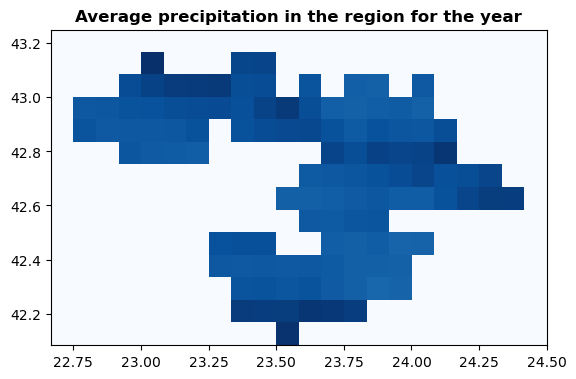

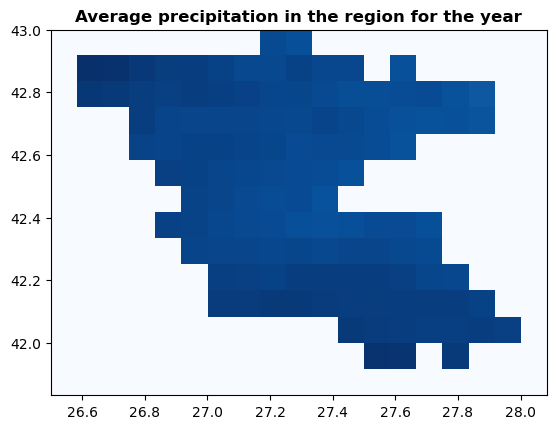

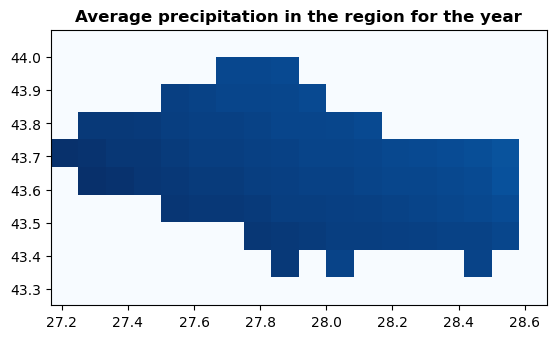

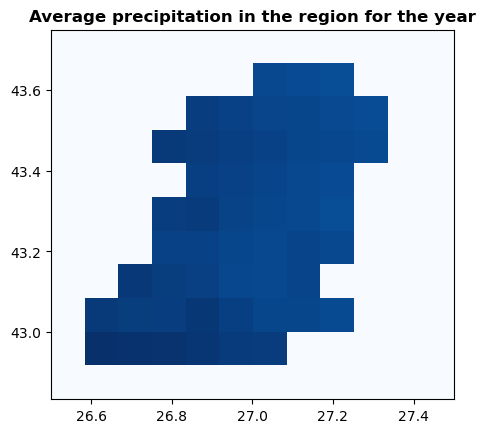

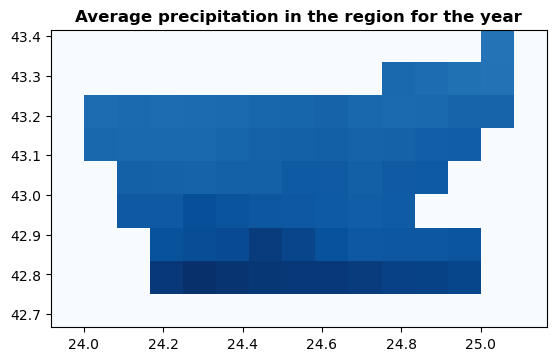

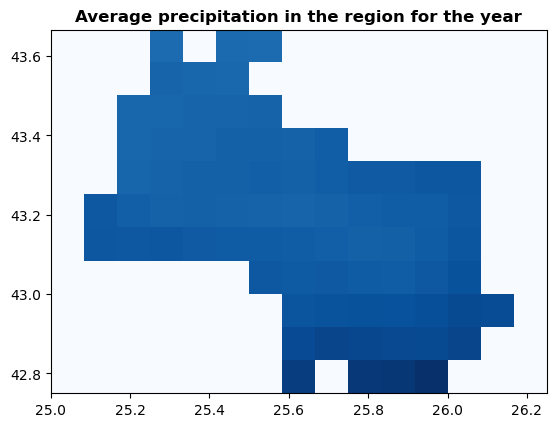

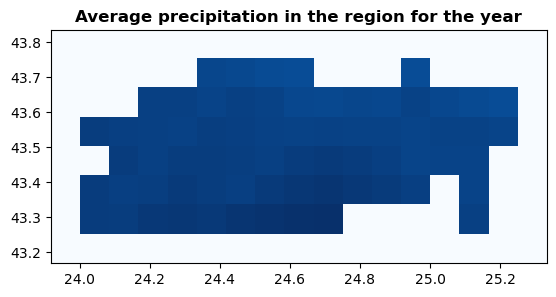

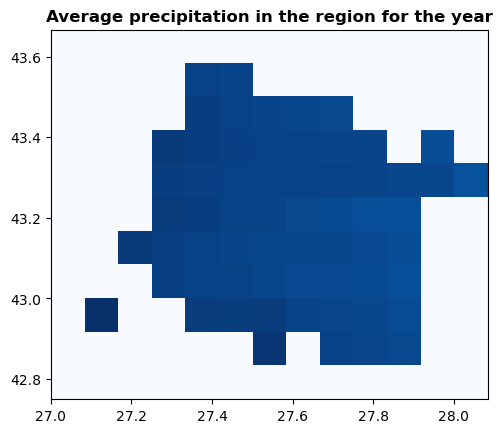

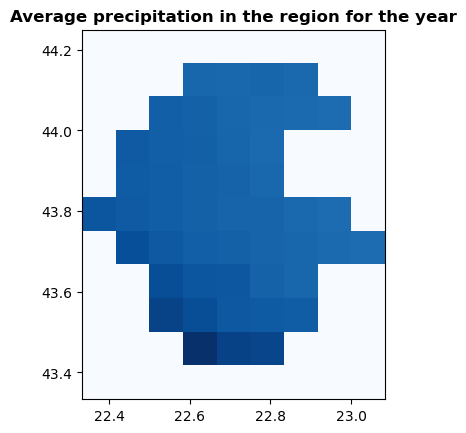

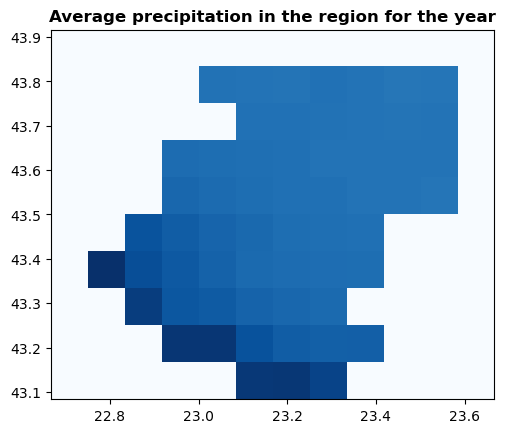

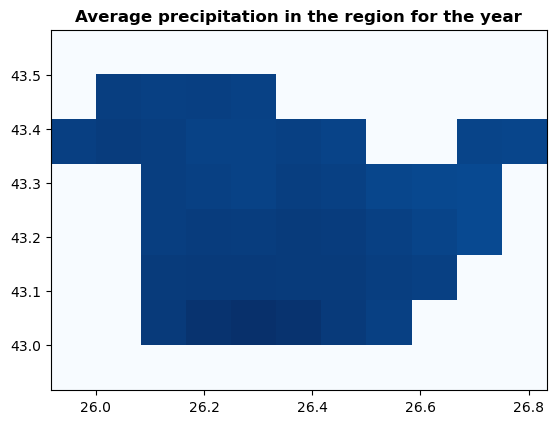

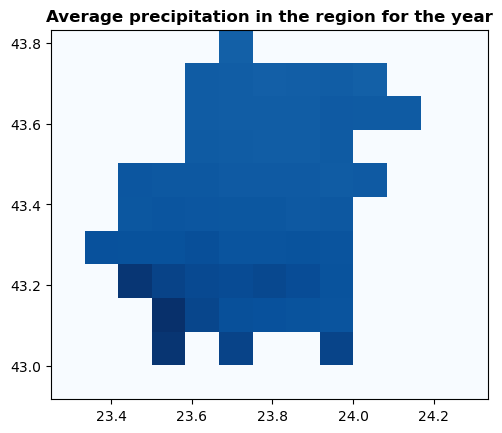

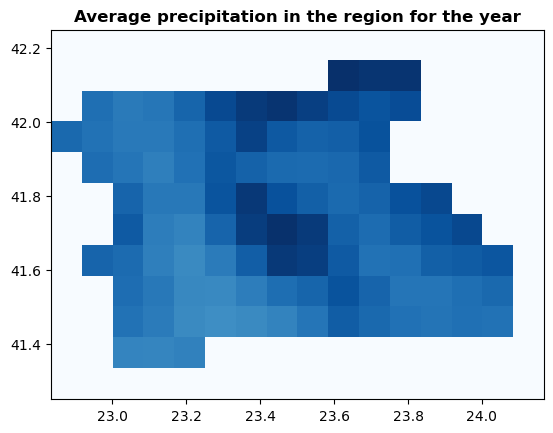

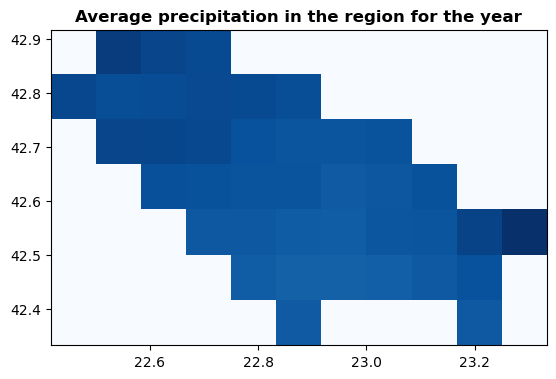

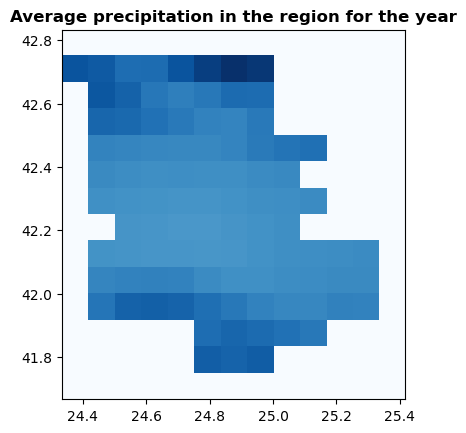

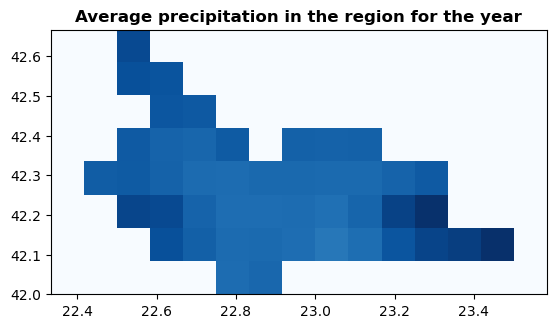

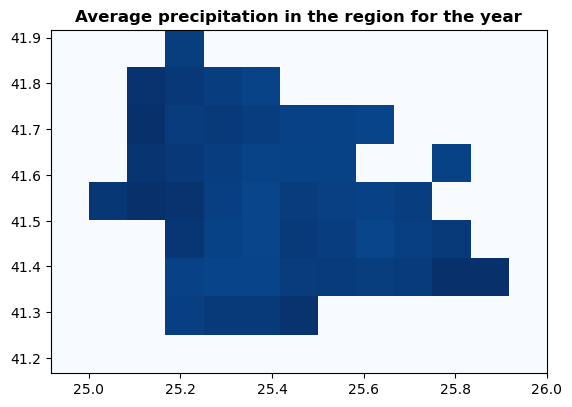

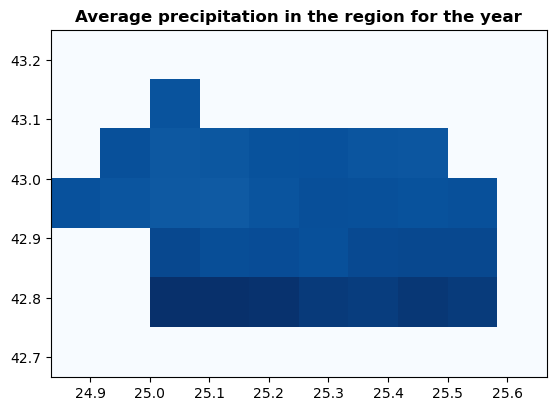

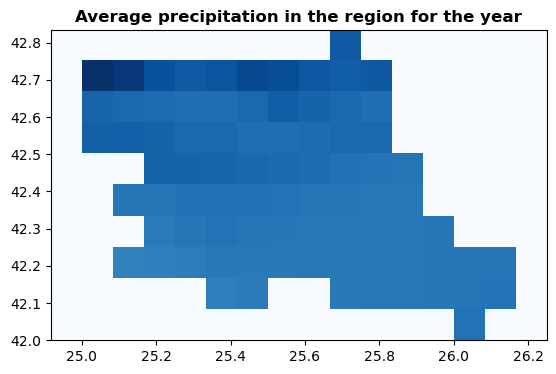

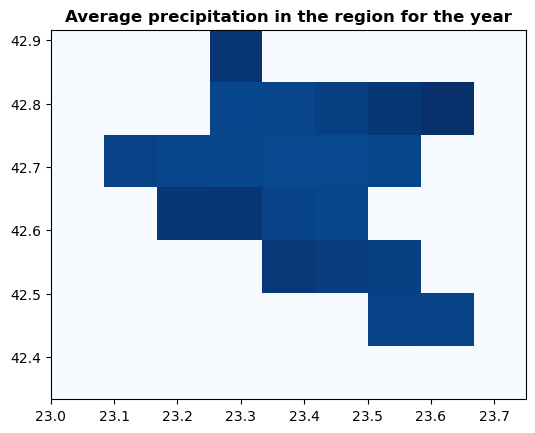

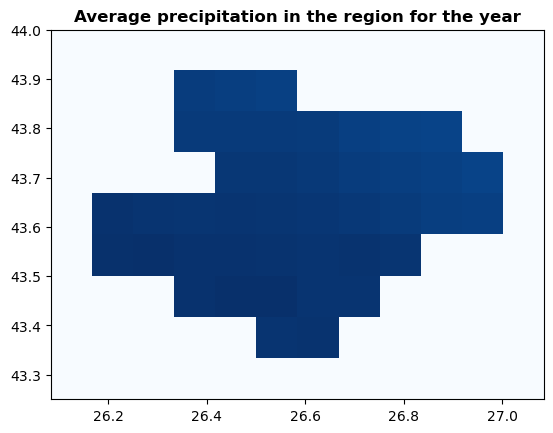

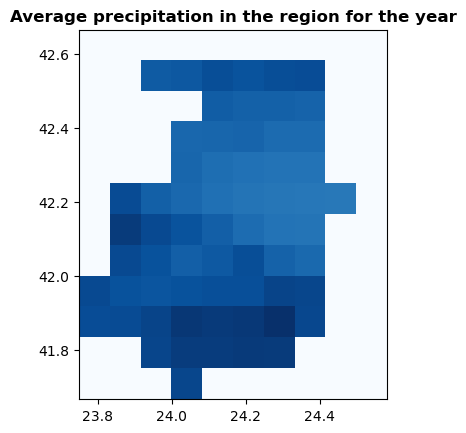

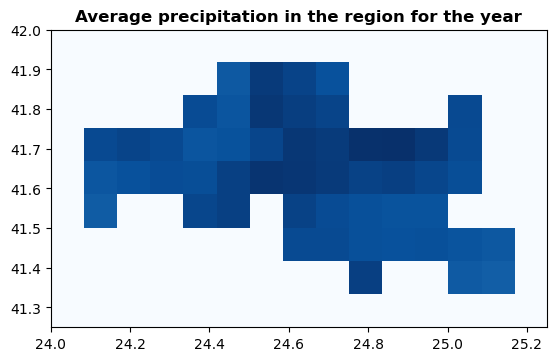

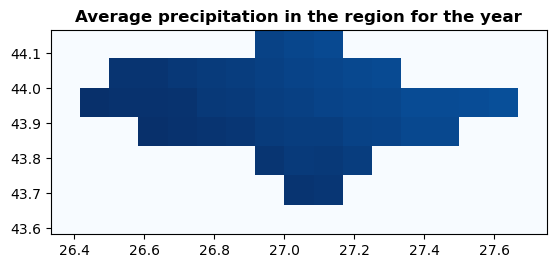

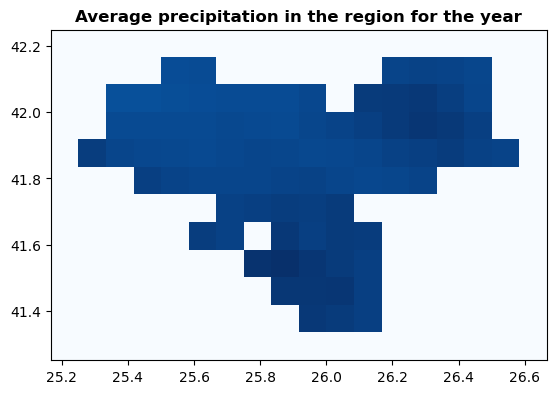

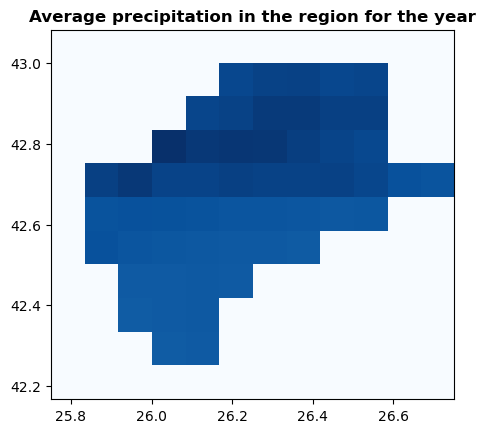

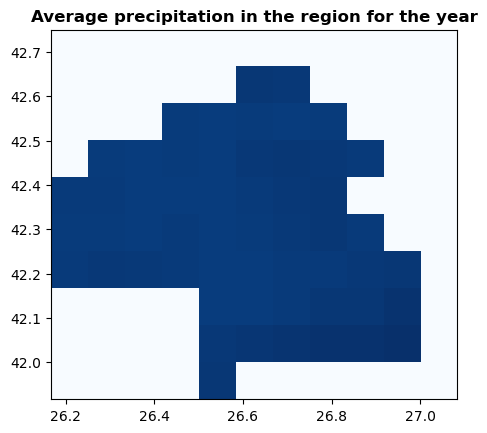

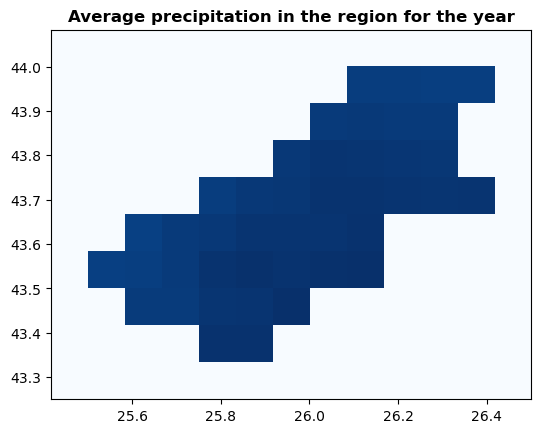

In [8]:
for city in cityname_imgs_all.keys():
    sumarray = np.zeros(cityname_imgs_all[city][0][0].shape)
    info = cityname_imgs_all[city]
    for i in range(0,12): #go through months
        numpyarr = info[i][0]
        transf = info[i][1]
        sumarray = sumarray +  numpyarr
    avgarray = sumarray/12
    show(avgarray, transform = transf, cmap = "Blues", title = 'Average precipitation in the region for the year')

    meta = month_prec.meta

    meta.update(
        compress='lzw',
        transform = transf,
        height = avgarray.shape[1],
            width = avgarray.shape[2])
    #save as a raster with the proper specifications
    with rasterio.open(f'C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\precip\\avgprec{city}.tiff', 'w', **meta) as dst:
            dst.write(avgarray.astype(rasterio.uint16))

    #open this newly saved raster
    rast = rasterio.open(f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\precip\\avgprec{city}.tiff")
    rastdata = rast.read(1)

    # get point of where the maximum average value for this city is
    indices = np.where(rastdata == rastdata.max()) 
    #print(f"Indices: {indices}")

    point = rast.xy(indices[0][0], indices[1][0])
    df = pd.DataFrame({"Latitude": point[1], "Longitude": point[0]}, index = [0])
    point = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = month_prec.crs)
    points_maxprec.append(point) #all the points

    rast.close()




In [9]:
maxpoints = pd.concat(points_maxprec).reset_index().drop('index', axis = 1)


In [10]:
type(maxpoints)

geopandas.geodataframe.GeoDataFrame

In [12]:
#maxpoints.to_file(r"C:\Users\User\Documents\GitHub\GeospatialAnalysisProject\Analysis_and_Exploration\Data\Climate\maxpoints_prec.geojson", driver='GeoJSON')

# Plot the regions with where the maximum precipitation has been

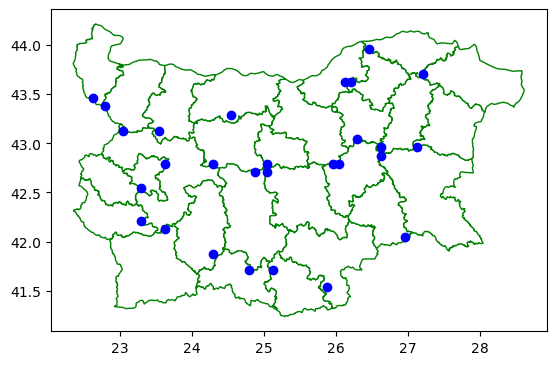

In [26]:
mxpointsprec = gpd.read_file("https://raw.githubusercontent.com/atanasova16/GeospatialAnalysisProject/main/Analysis_and_Exploration/Data/Climate/maxpoints_prec.geojson")
ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
mxpointsprec.plot(ax = ax, color = "blue")

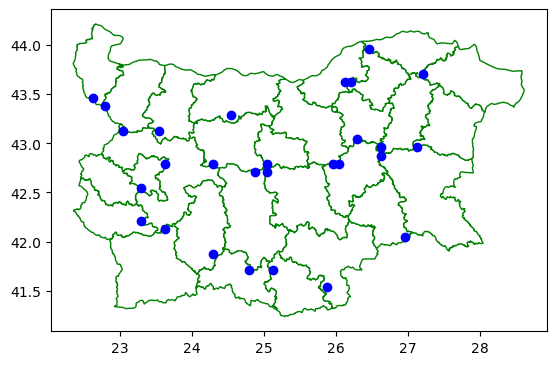

In [13]:
# ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
# maxpoints.plot(ax = ax, color = "blue")

Most precipitation appears to be in the mountains

## Temperature

In [14]:
all_months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
images_districts_permonths = {}

for m in all_months:
    file_name_temp = f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\precipitation\\wc2.1_2.5m_tavg\\wc2.1_2.5m_tavg_{m}.tif"
    month_temp = rasterio.open(file_name_temp)
    month_data = month_temp.read(1)
    month_data[month_data == -3.39999995e+38] = -100

    
    images_districts_permonths[m] = []

    for district in districtsnames:
        geom = bg[bg.NAME_LATN == district].geometry
        coords = getFeatures(geom)

        out_img, out_transform = mask(month_temp, coords, crop=True)
        out_meta = month_temp.meta
        out_img[out_img == -3.39999995e+38] = -100
        out_img = out_img.astype(float)
        out_img[out_img == -100] = np.nan

        average_m = out_img[out_img != -100].mean()

        images_districts_permonths[m].append((district, out_img, out_transform))

    month_temp.close()

In [15]:
cityname_imgs_all = {}

for m in images_districts_permonths.keys():
    monthvalues = images_districts_permonths[m]

    for city in monthvalues:
        cityname = city[0]
        if cityname not in cityname_imgs_all.keys():
            cityname_imgs_all[cityname] = []
        numpyimg = city[1]
        transf = city[2]
        cityname_imgs_all[cityname].append((numpyimg, transf))

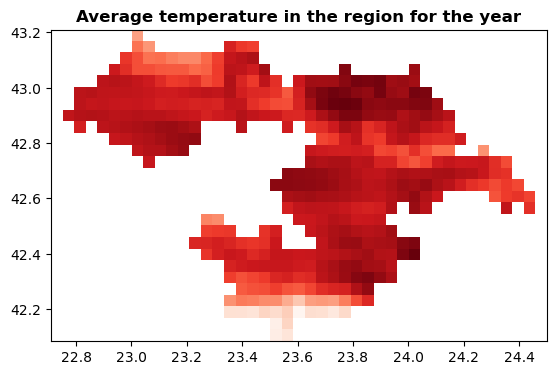

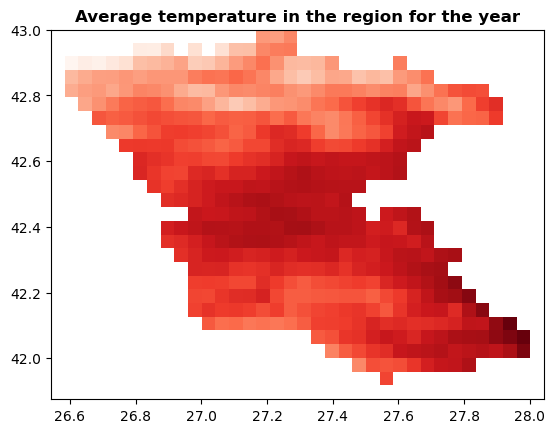

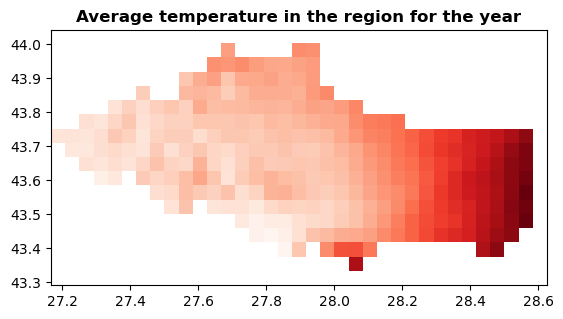

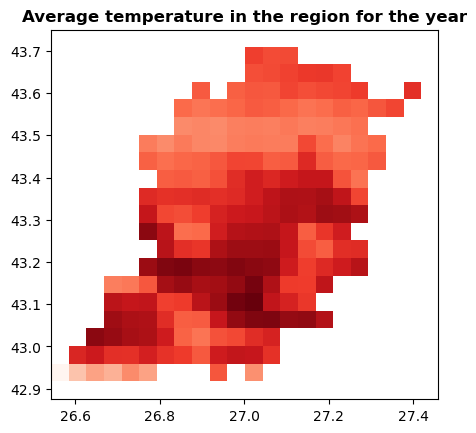

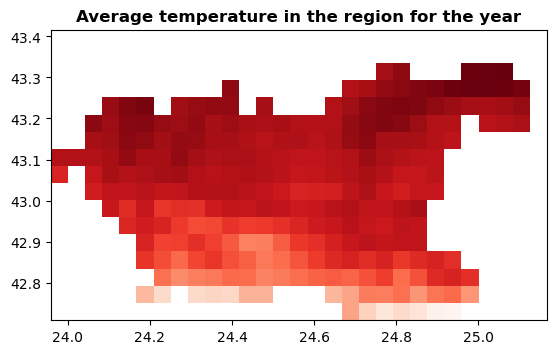

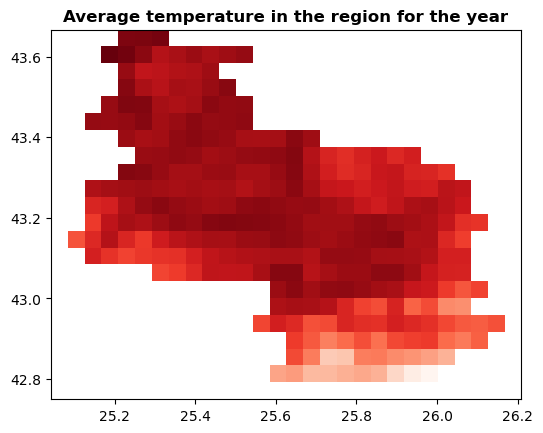

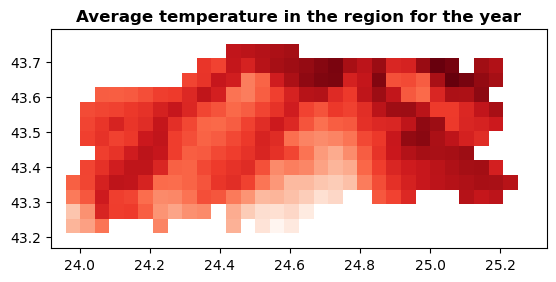

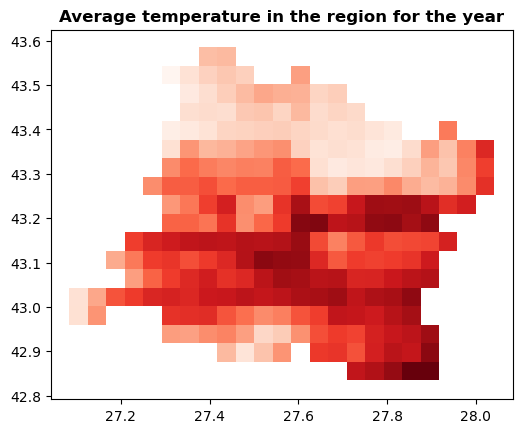

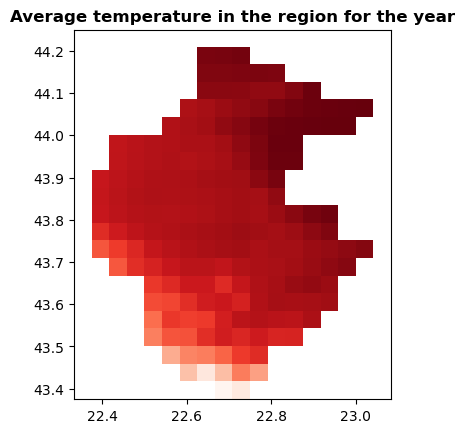

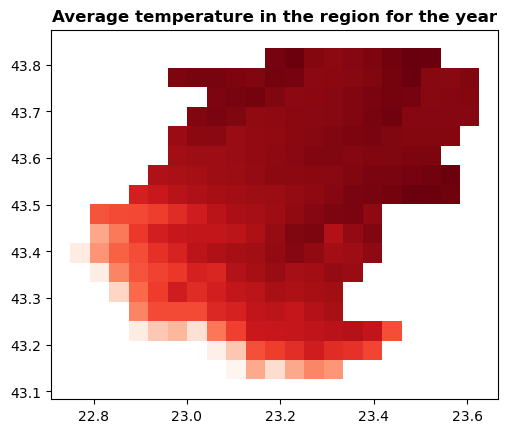

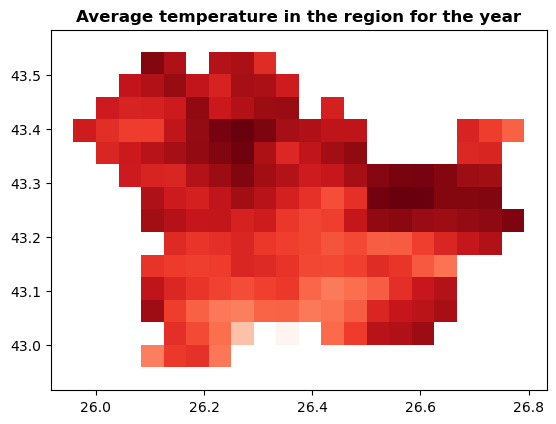

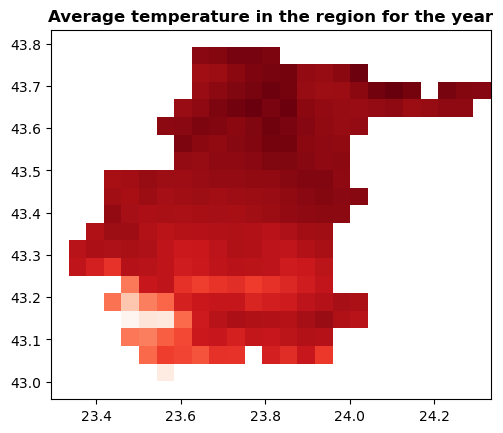

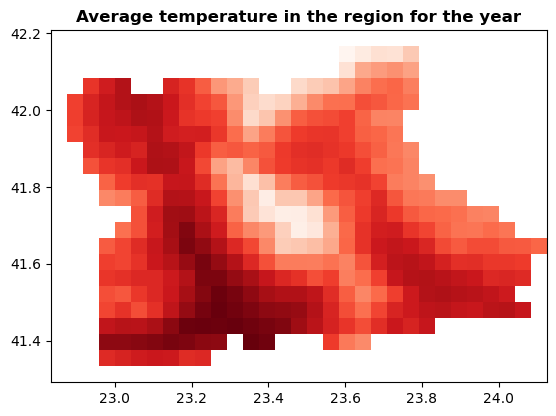

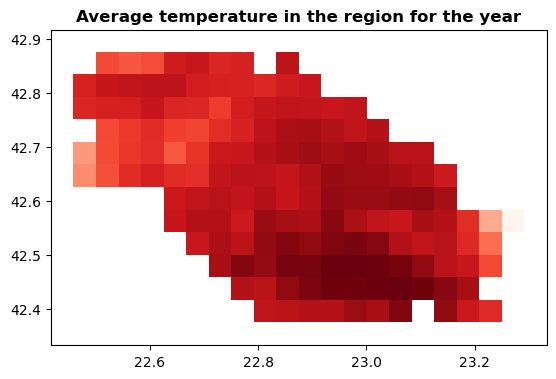

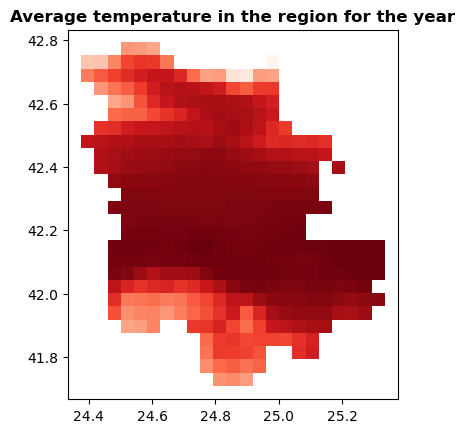

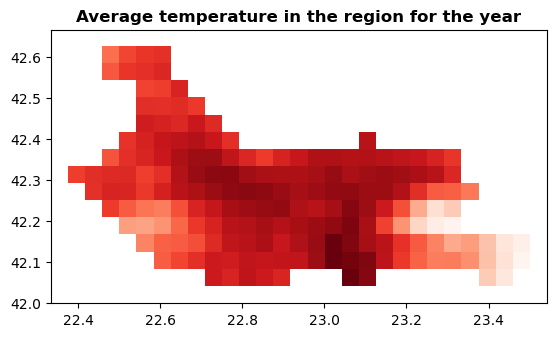

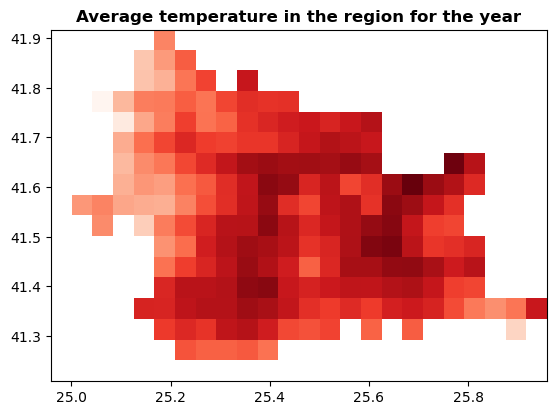

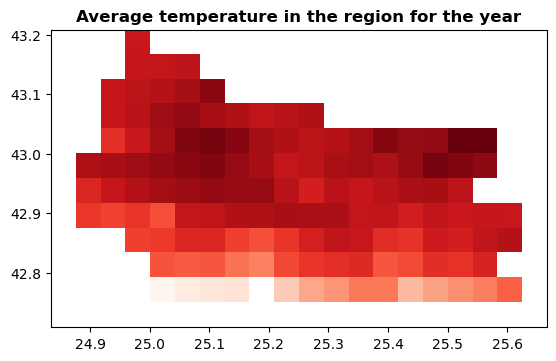

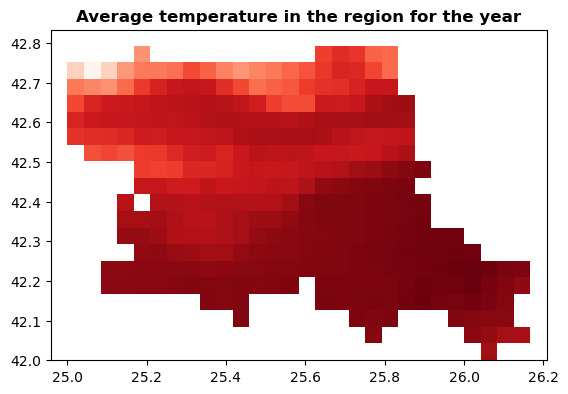

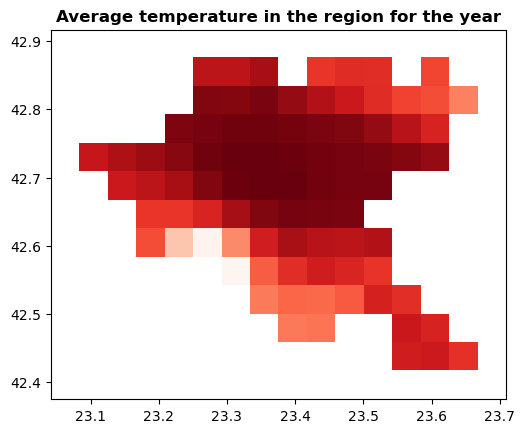

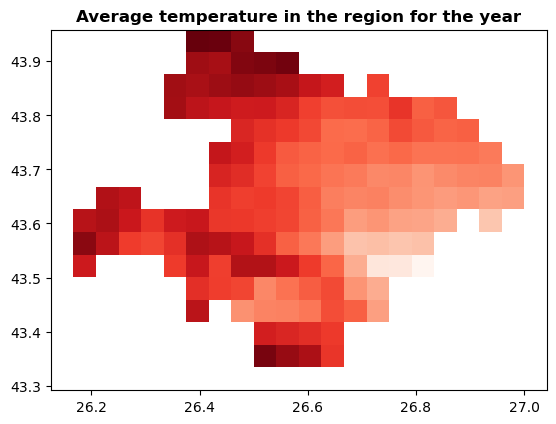

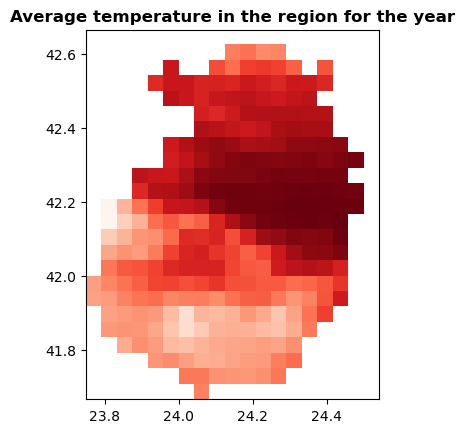

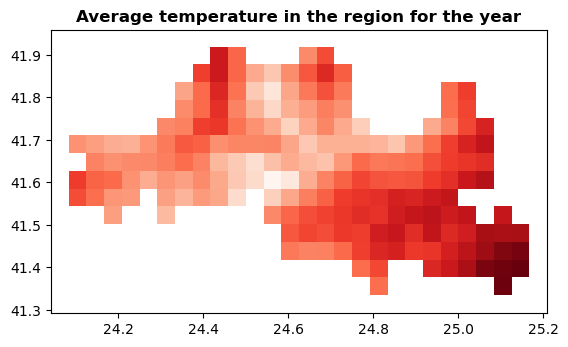

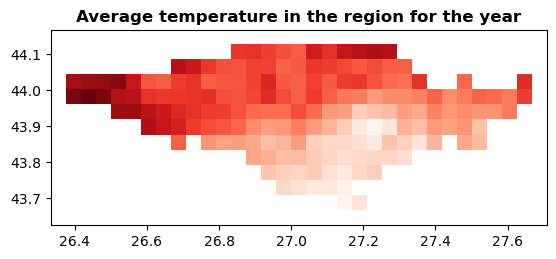

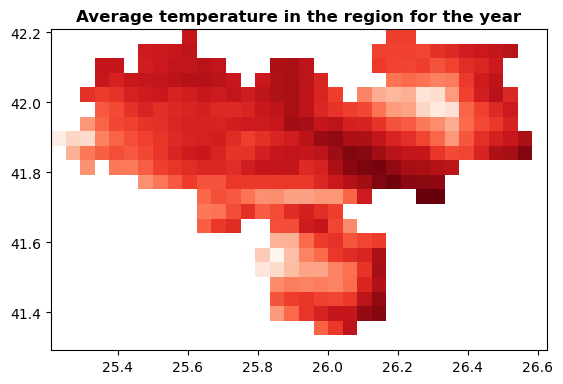

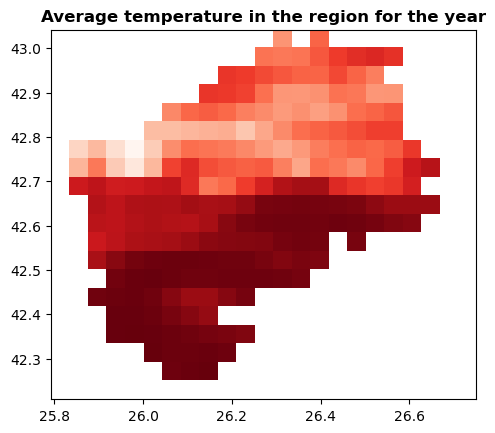

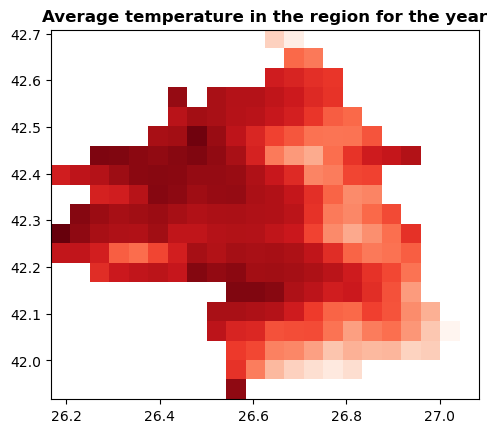

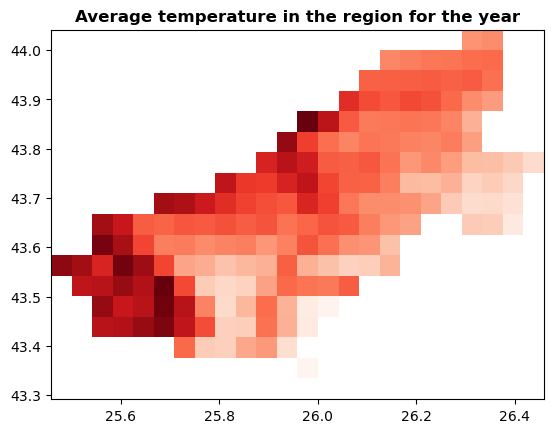

In [16]:
points_maxtemp = []

for city in cityname_imgs_all.keys():
    sumarray = np.zeros(cityname_imgs_all[city][0][0].shape)
    info = cityname_imgs_all[city]
    for i in range(0,12): #go through months
        numpyarr = info[i][0]
        transf = info[i][1]
        sumarray = sumarray +  numpyarr
    avgarray = sumarray/12
    show(avgarray, transform = transf, cmap = "Reds", title = 'Average temperature in the region for the year')

    meta = month_prec.meta

    meta.update(
        compress='lzw',
        transform = transf,
        height = avgarray.shape[1],
            width = avgarray.shape[2])
    #save as a raster with the proper specifications
    with rasterio.open(f'C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\temper\\avgtemp{city}.tiff', 'w', **meta) as dst:
            dst.write(avgarray.astype(rasterio.uint16))

    #open this newly saved raster
    rast = rasterio.open(f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\temper\\avgtemp{city}.tiff")
    rastdata = rast.read(1)

    # get point of where the maximum average value for this city is
    indices = np.where(rastdata == rastdata.max()) 
    #print(f"Indices: {indices}")

    point = rast.xy(indices[0][0], indices[1][0])
    df = pd.DataFrame({"Latitude": point[1], "Longitude": point[0]}, index = [0])
    point = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = month_prec.crs)
    points_maxtemp.append(point) #all the points

    rast.close()



In [17]:
maxpointstemp = pd.concat(points_maxtemp).reset_index().drop('index', axis = 1)

In [25]:
#maxpointstemp.to_file(r"C:\Users\User\Documents\GitHub\GeospatialAnalysisProject\Analysis_and_Exploration\Data\Climate\maxpoints_temp.geojson", driver='GeoJSON')

# Plot the points

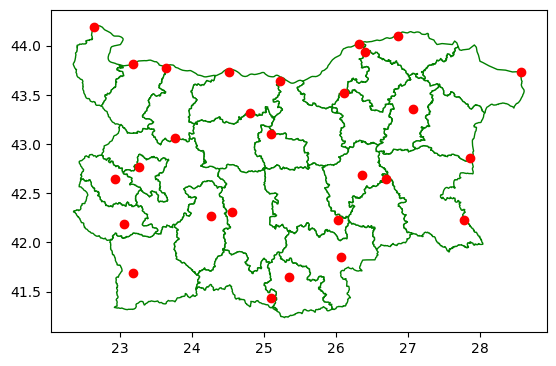

In [27]:
mxpointstemp = gpd.read_file("https://raw.githubusercontent.com/atanasova16/GeospatialAnalysisProject/main/Analysis_and_Exploration/Data/Climate/maxpoints_temp.geojson")
ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
mxpointstemp.plot(ax = ax, color = "red")

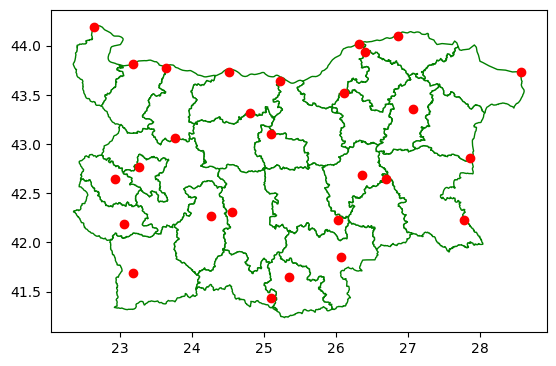

In [83]:
# ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
# maxpointstemp.plot(ax = ax, color = "red")

## Wind Speed

In [20]:
all_months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
images_districts_permonths = {}

for m in all_months:
    file_name_wind = f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\raster\\precipitation\\wc2.1_5m_wind\\wc2.1_5m_wind_{m}.tif"
    month_wind = rasterio.open(file_name_wind)
    month_data = month_wind.read(1)
    month_data = month_data.astype(float)
    month_data[month_data == -3.3999999521443642e+38] = np.nan

    
    images_districts_permonths[m] = []

    for district in districtsnames:
        geom = bg[bg.NAME_LATN == district].geometry
        coords = getFeatures(geom)

        out_img, out_transform = mask(month_wind, coords, crop=True)
        out_meta = month_wind.meta
        out_img[out_img == -3.3999999521443642e+38] = -100
        out_img = out_img.astype(float)
        out_img[out_img == -100] = np.nan

        average_m = out_img[out_img != -100].mean()

        images_districts_permonths[m].append((district, out_img, out_transform))

    month_wind.close()

In [21]:

cityname_imgs_all = {}

for m in images_districts_permonths.keys():
    monthvalues = images_districts_permonths[m]

    for city in monthvalues:
        cityname = city[0]
        if cityname not in cityname_imgs_all.keys():
            cityname_imgs_all[cityname] = []
        numpyimg = city[1]
        transf = city[2]
        cityname_imgs_all[cityname].append((numpyimg, transf))

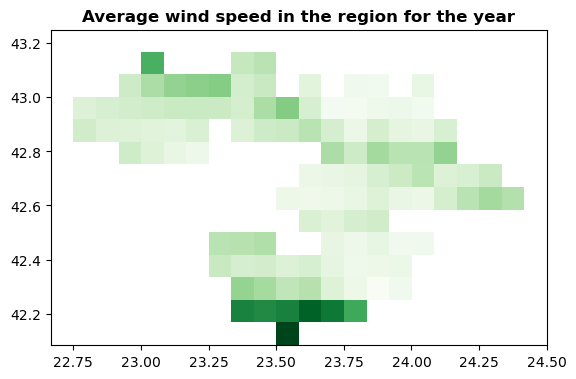

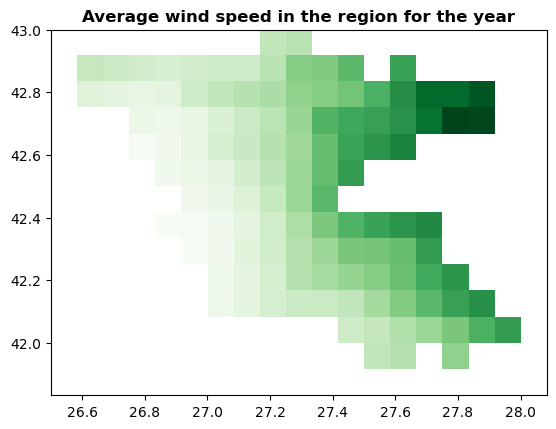

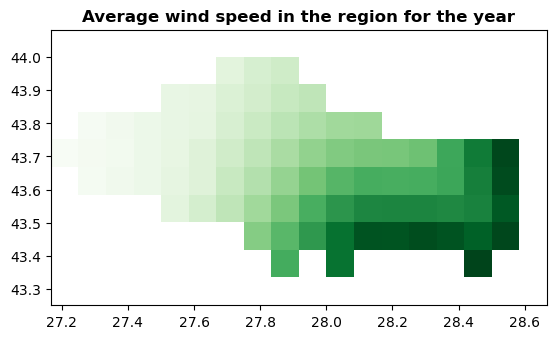

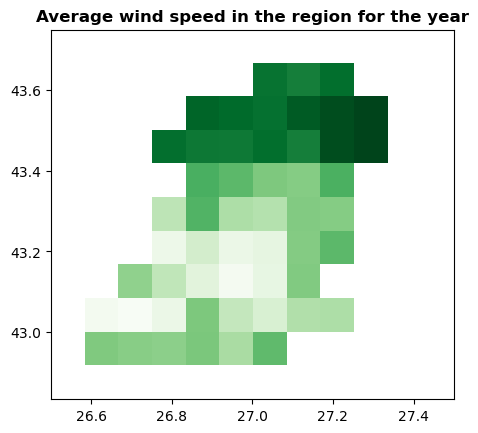

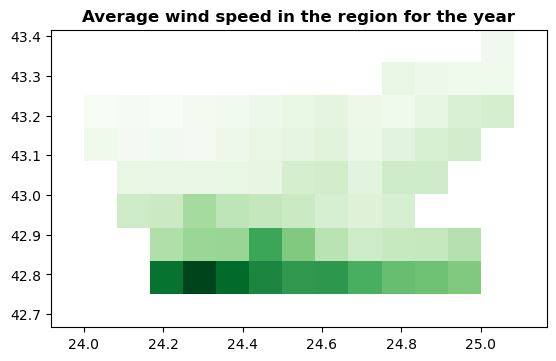

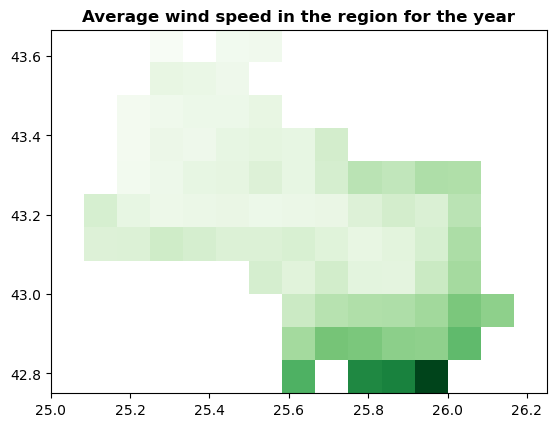

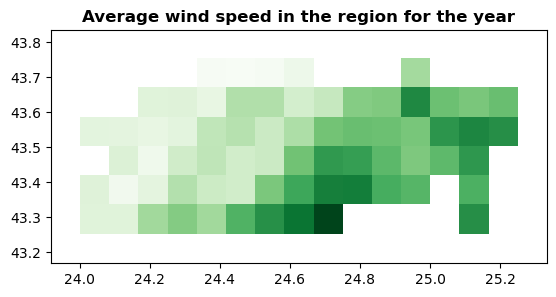

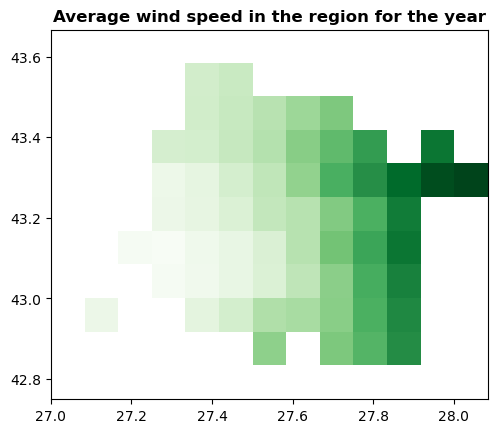

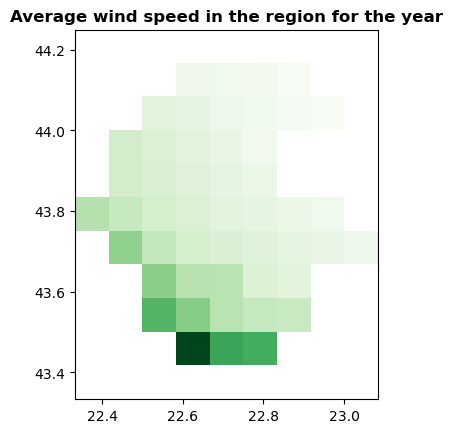

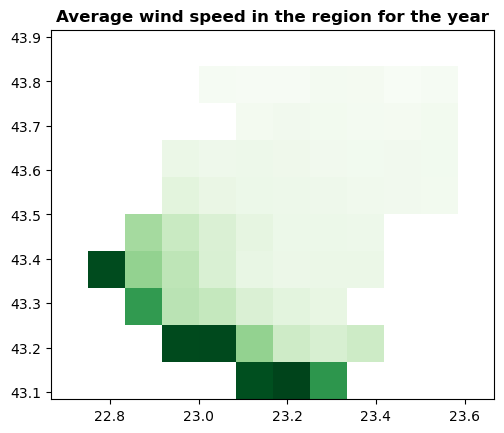

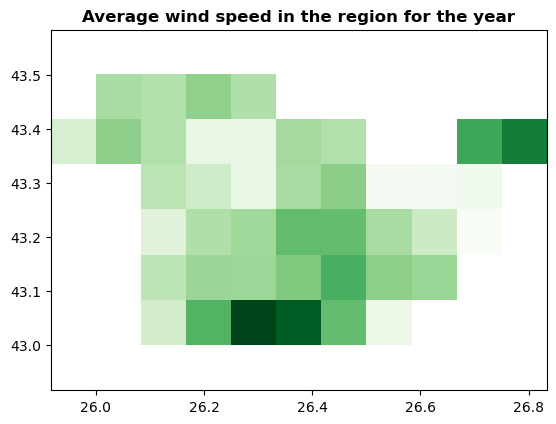

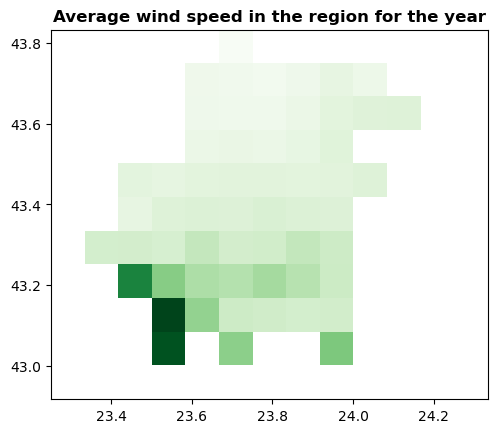

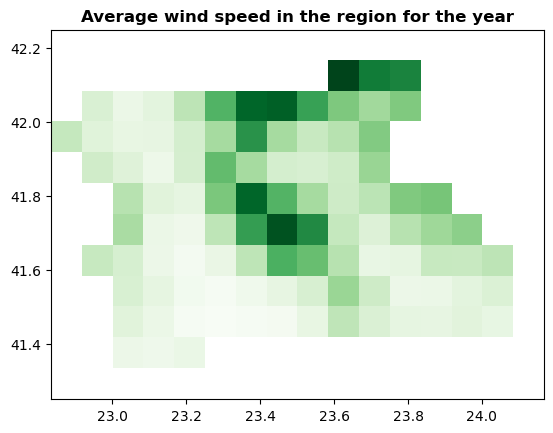

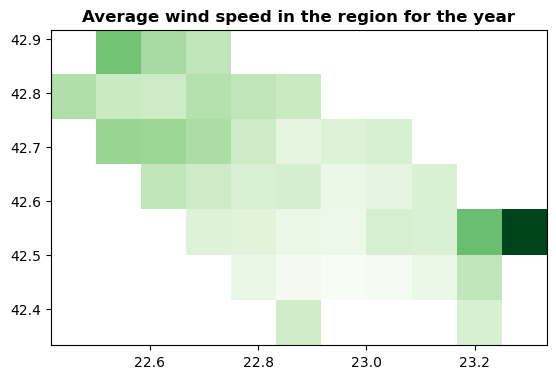

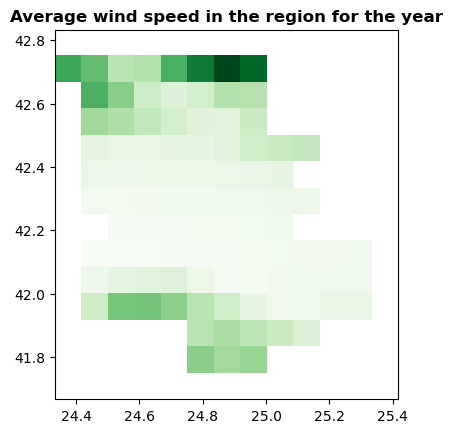

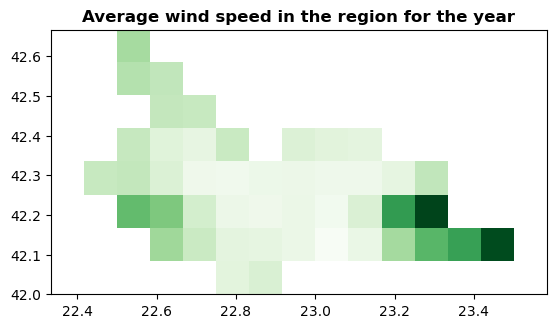

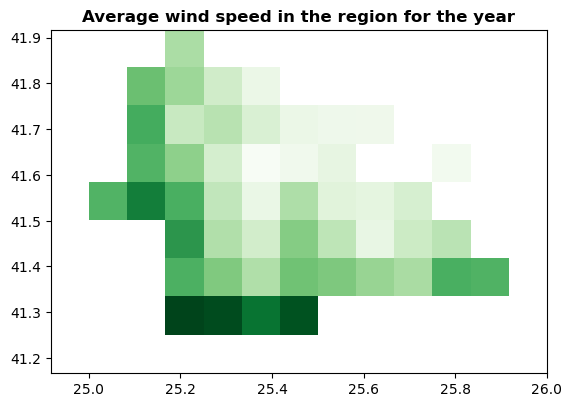

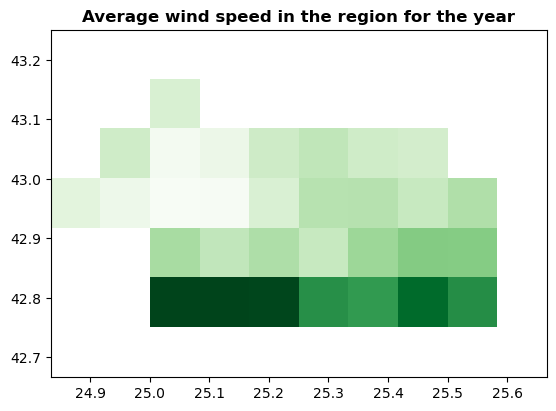

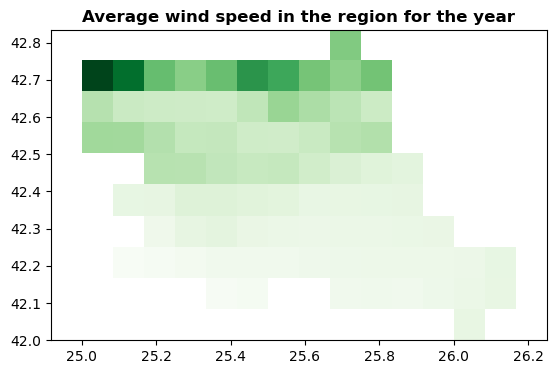

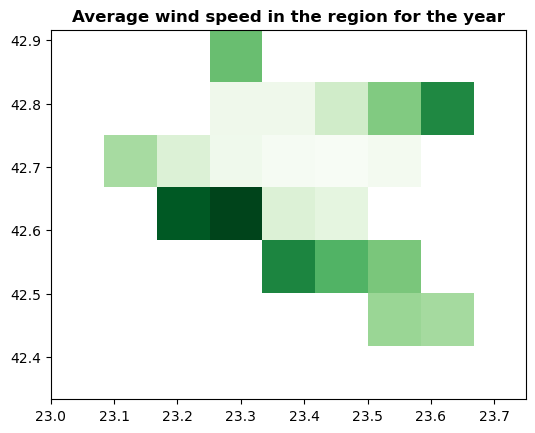

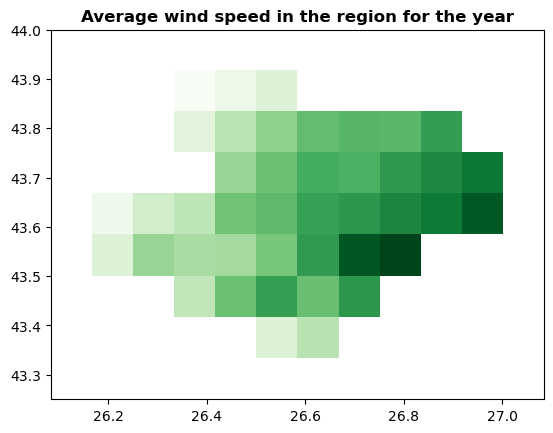

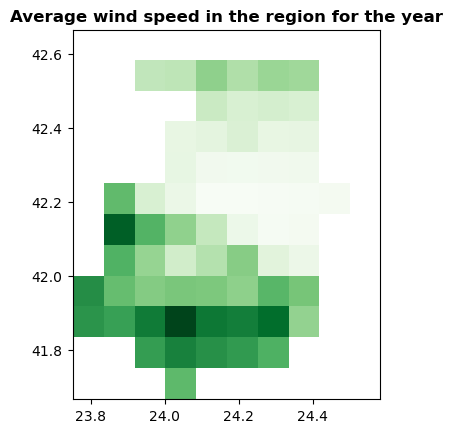

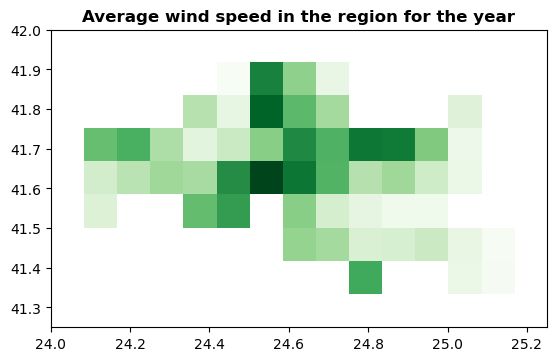

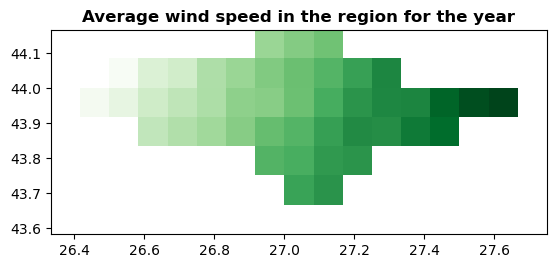

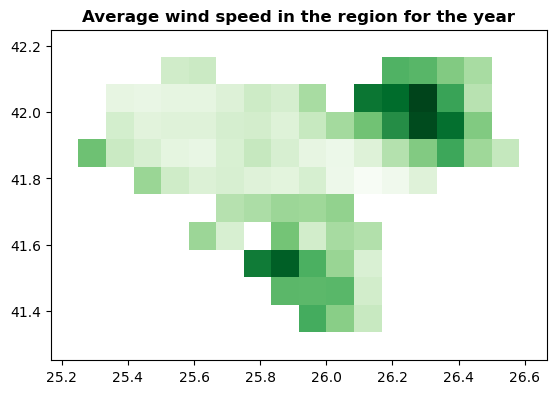

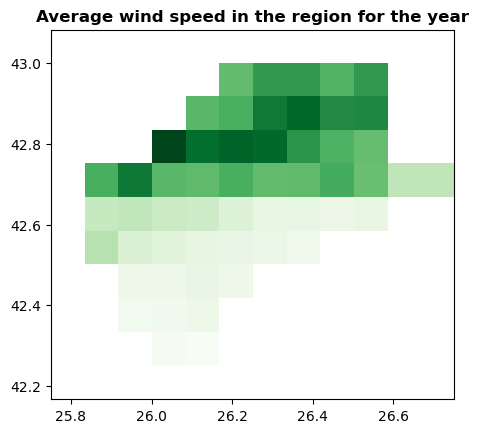

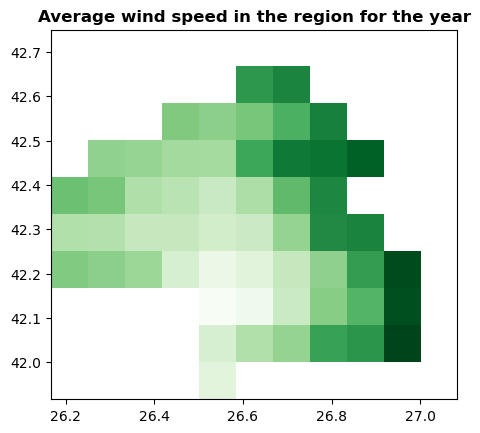

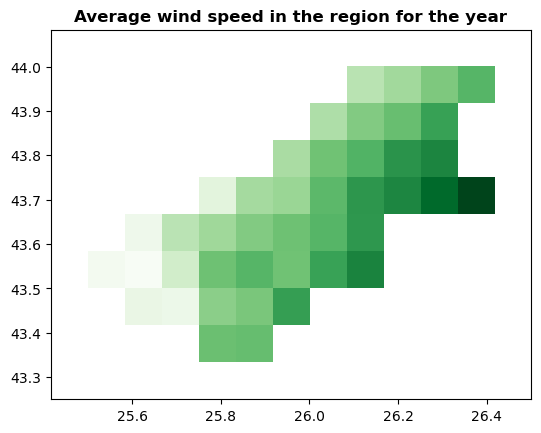

In [22]:

points_maxwind = []

for city in cityname_imgs_all.keys():
    sumarray = np.zeros(cityname_imgs_all[city][0][0].shape)
    info = cityname_imgs_all[city]
    for i in range(0,12): #go through months
        numpyarr = info[i][0]
        transf = info[i][1]
        sumarray = sumarray +  numpyarr
    avgarray = sumarray/12
    show(avgarray, transform = transf, cmap = "Greens", title = 'Average wind speed in the region for the year')

    meta = month_prec.meta

    meta.update(
        compress='lzw',
        transform = transf,
        height = avgarray.shape[1],
            width = avgarray.shape[2])
    #save as a raster with the proper specifications
    with rasterio.open(f'C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\wind\\avgwind{city}.tiff', 'w', **meta) as dst:
            dst.write(avgarray.astype(rasterio.uint16))

    #open this newly saved raster
    rast = rasterio.open(f"C:\\Users\\User\\Documents\\UNITN\\Geospatial\\For_GITHUB_project\\Plovdiv_Infographics\\Data\\Climate\\averages_tiff_climatevariables\\wind\\avgwind{city}.tiff")
    rastdata = rast.read(1)

    # get point of where the maximum average value for this city is
    indices = np.where(rastdata == rastdata.max()) 
    #print(f"Indices: {indices}")

    point = rast.xy(indices[0][0], indices[1][0])
    df = pd.DataFrame({"Latitude": point[1], "Longitude": point[0]}, index = [0])
    point = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = month_prec.crs)
    points_maxwind.append(point) #all the points

    rast.close()



In [ ]:
maxpointswind = pd.concat(points_maxwind).reset_index().drop('index', axis = 1)

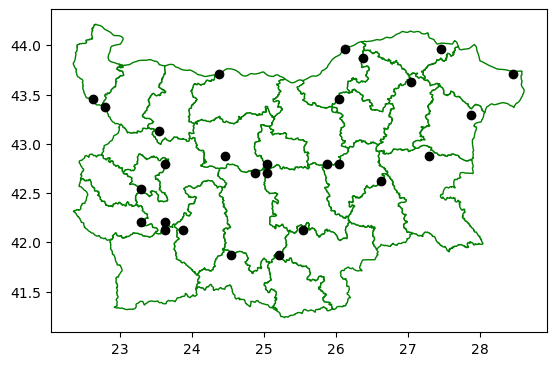

In [23]:
# ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
# maxpointswind.plot(ax = ax, color = "black")

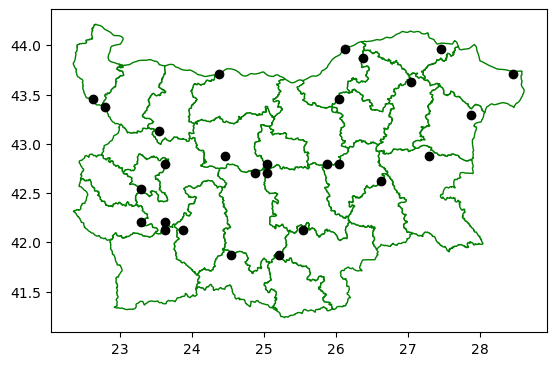

In [28]:
mxpointswind = gpd.read_file("https://raw.githubusercontent.com/atanasova16/GeospatialAnalysisProject/main/Analysis_and_Exploration/Data/Climate/maxpoints_wind.geojson")
ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
mxpointswind.plot(ax = ax, color = "black")

In [24]:
#maxpointswind.to_file(r"C:\Users\User\Documents\GitHub\GeospatialAnalysisProject\Analysis_and_Exploration\Data\Climate\maxpoints_wind.geojson", driver='GeoJSON')

In [31]:
mxpointsprec['variable'] = "precipitation"
mxpointstemp['variable'] = "temperature"
mxpointswind['variable'] = 'windspeed'

In [41]:
import contextily as cx

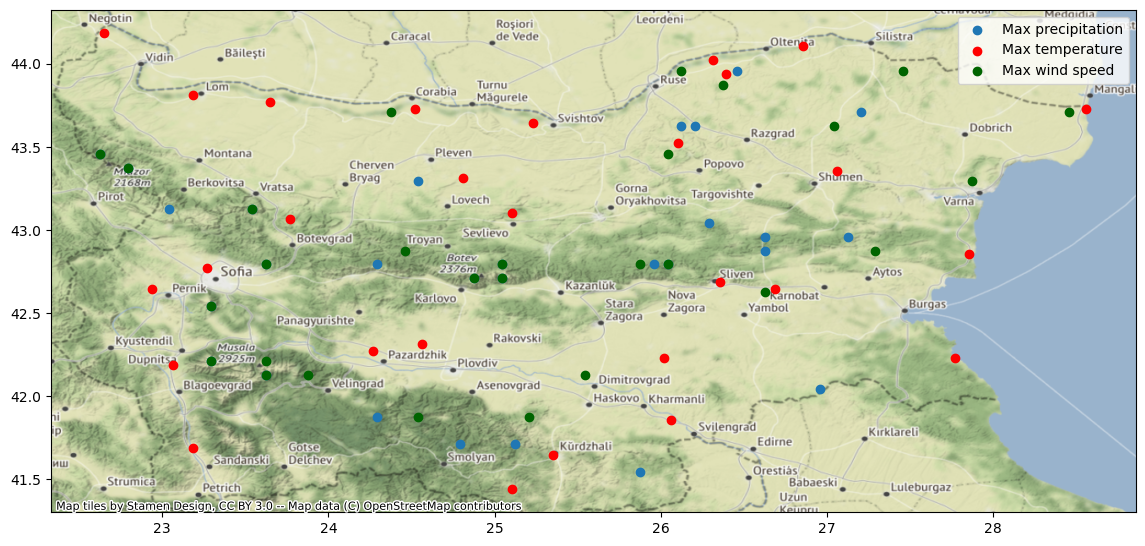

In [54]:
ax = mxpointsprec.plot(figsize=(14, 14))
mxpointstemp.plot( color='red', ax = ax)
mxpointswind.plot(color = "darkgreen", ax = ax)
ax.legend({"Max precipitation":1, "Max temperature": 'red', "Max wind speed": 'darkgreen'})
cx.add_basemap(ax = ax, crs = mxpointsprec.crs) #, source=cx.providers.Stamen.TonerLite)

# Appendix


In [43]:
nightlights = cx.providers.NASAGIBS.ViirsEarthAtNight2012
bglights = cx.Place("Bulgaria", source=nightlights)

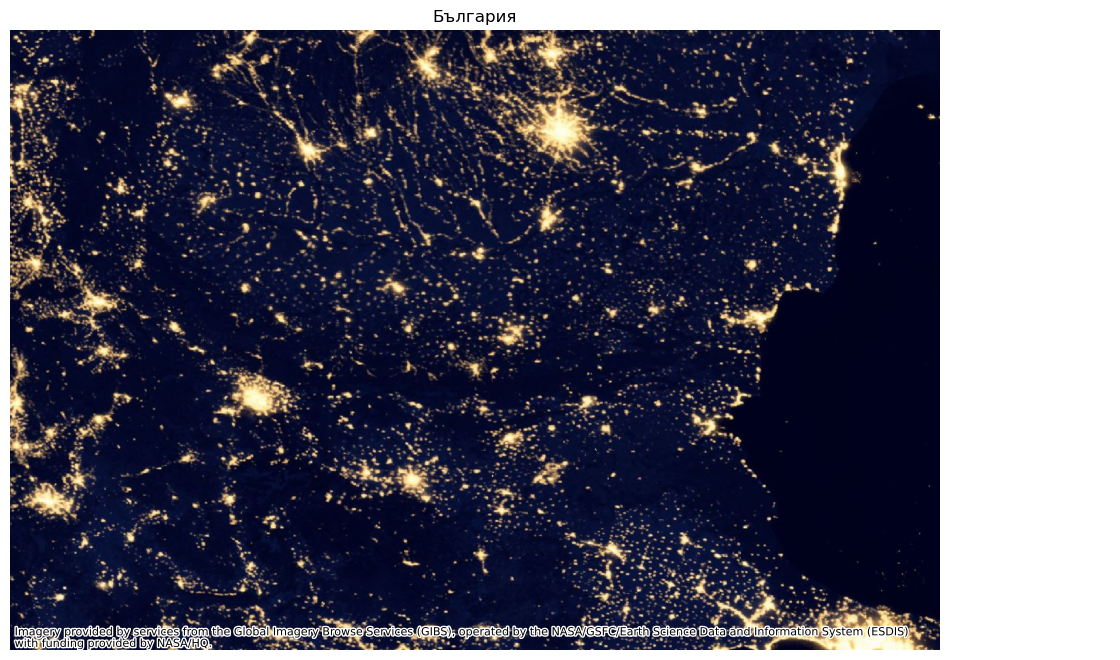

In [45]:
bglights.plot()

In [21]:
cityname_imgs = []

for m in images_districts_permonths.keys():
    monthvalues = images_districts_permonths[m]
    for city in monthvalues:
        if city[0] == "Sofia":
            numpyimg = city[1]
            transf = city[2]
            cityname_imgs.append((numpyimg, transf))

In [46]:
sumarray = np.zeros(cityname_imgs[0][0].shape)
for m in cityname_imgs:
    sumarray = sumarray +  m[0]


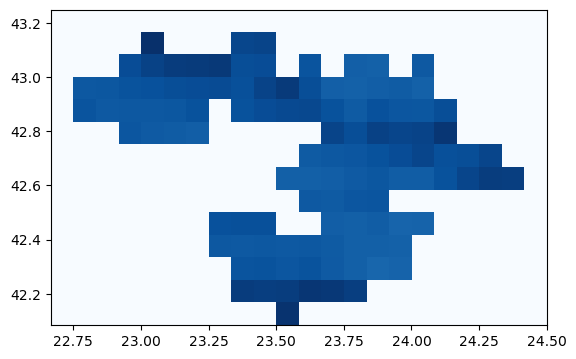

In [49]:
avgarray = sumarray/12
show(avgarray, transform = m[1], cmap = "Blues")

Indices: (array([1], dtype=int64), array([4], dtype=int64))


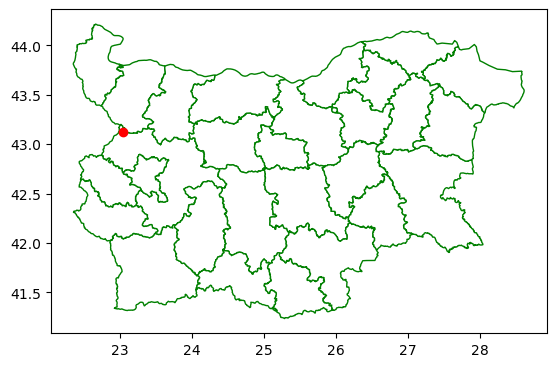

In [51]:
meta = month_prec.meta

meta.update(
       #dtype=rasterio.uint8,
       compress='lzw',
       transform = m[1],
       height = avgarray.shape[1],
        width = avgarray.shape[2])

with rasterio.open(r'C:\Users\User\Documents\UNITN\Geospatial\raster\acaso2.tiff', 'w', **meta) as dst:
        dst.write(avgarray.astype(rasterio.uint16))

acaso2 = rasterio.open(r"C:\Users\User\Documents\UNITN\Geospatial\raster\acaso2.tiff")
acaso2data = acaso2.read(1)

indices = np.where(acaso2data == acaso2data.max())
print(f"Indices: {indices}")

point = acaso2.xy(indices[0][0], indices[1][0])
df = pd.DataFrame({"Latitude": point[1], "Longitude": point[0]}, index = [0])
point = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = month_prec.crs)

ax = bg.to_crs(4326).plot(color = "white", edgecolor = "green")
point.plot(ax = ax, color = "red")